In [2]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.layers import Input, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
import numpy as np
import matplotlib.pyplot as plt 
import h5py

In [2]:
#"phenomene","pitch","tension","breathiness","voicing","gender","toneshift"
N=10500
data_path='C:\\Users\\Lenovo\\Desktop\\autocover_test\\resnet\\dataset\\'
data_x=np.zeros(shape=(N,128,128,1),dtype=(np.float))
for i in range(N):
    if (i/N*100)%5==0:
        print('%d'%(i/N*100)+'%')
    t=h5py.File(data_path+'%05d.mat'%(i+1))
    t=t['MEL'][:]
    t=np.log(t+1e-20)+40
    data_x[i,:,:,0]=t
print(np.shape(data_x))

f=open(data_path+'params.txt')
range_param=[[-1,1],[-1,1],[0.2,1],[-0.1,0.1],[-400,400]]
data_y=[];
for line in f:
    data_y.append(line.split())
    data_y[-1]=data_y[-1][2:]
    for i in range(5):
        data_y[-1][i]=(float(data_y[-1][i])-range_param[i][0])/(range_param[i][1]-range_param[i][0])
data_y=np.array(data_y)
print(np.shape(data_y))
print(data_y[0])

0%


d:\software\python36x64\lib\site-packages\ipykernel_launcher.py:8: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
60%
65%
70%
75%
80%
85%
90%
95%
(10500, 128, 128, 1)
(10500, 5)
[0.26595201 0.13623012 0.92718824 0.63776558 0.52257525]


31.486686120998208
8.819108459059816


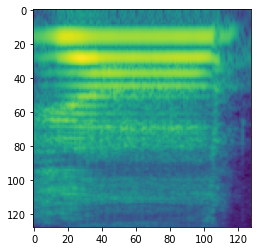

In [3]:
plt.imshow(np.transpose(data_x[0,:,:,0]))
print(np.max(data_x[0,:,:,0]))
print(np.min(data_x[0,:,:,0]))

In [3]:
def Conv_BN_Relu(filters, kernel_size, strides, input_layer):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


# ResNet18网络对应的残差模块a和残差模块b
def residual_a_or_b(input_x, filters, flag):
    if flag == 'a':
        # 主路
        x = Conv_BN_Relu(filters, (3, 3), 1, input_x)
        x = Conv_BN_Relu(filters, (3, 3), 1, x)

        # 输出
        y = Add()([x, input_x])

        return y
    elif flag == 'b':
        # 主路
        x = Conv_BN_Relu(filters, (3, 3), 2, input_x)
        x = Conv_BN_Relu(filters, (3, 3), 1, x)

        # 支路下采样
        input_x = Conv_BN_Relu(filters, (1, 1), 2, input_x)

        # 输出
        y = Add()([x, input_x])

        return y
    # 其实还有更简单的封装方式，是python编程的知识了，我就不再多阐述了，主要是让同学们理解流程


# 第一层
input_layer = Input((128, 128, 1))
conv1 = Conv_BN_Relu(64, (7, 7), 1, input_layer)
conv1_Maxpooling = MaxPooling2D((3, 3), strides=2, padding='same')(conv1)

# conv2_x
x = residual_a_or_b(conv1_Maxpooling, 64, 'b')
x = residual_a_or_b(x, 64, 'a')

# conv3_x
x = residual_a_or_b(x, 128, 'b')
x = residual_a_or_b(x, 128, 'a')

# conv4_x
x = residual_a_or_b(x, 256, 'b')
x = residual_a_or_b(x, 256, 'a')

# conv5_x
x = residual_a_or_b(x, 512, 'b')
x = residual_a_or_b(x, 512, 'a')

# 最后一层
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1000)(x)
x = Dropout(0.5)(x)
y = Dense(5)(x)
model = Model([input_layer], [y])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


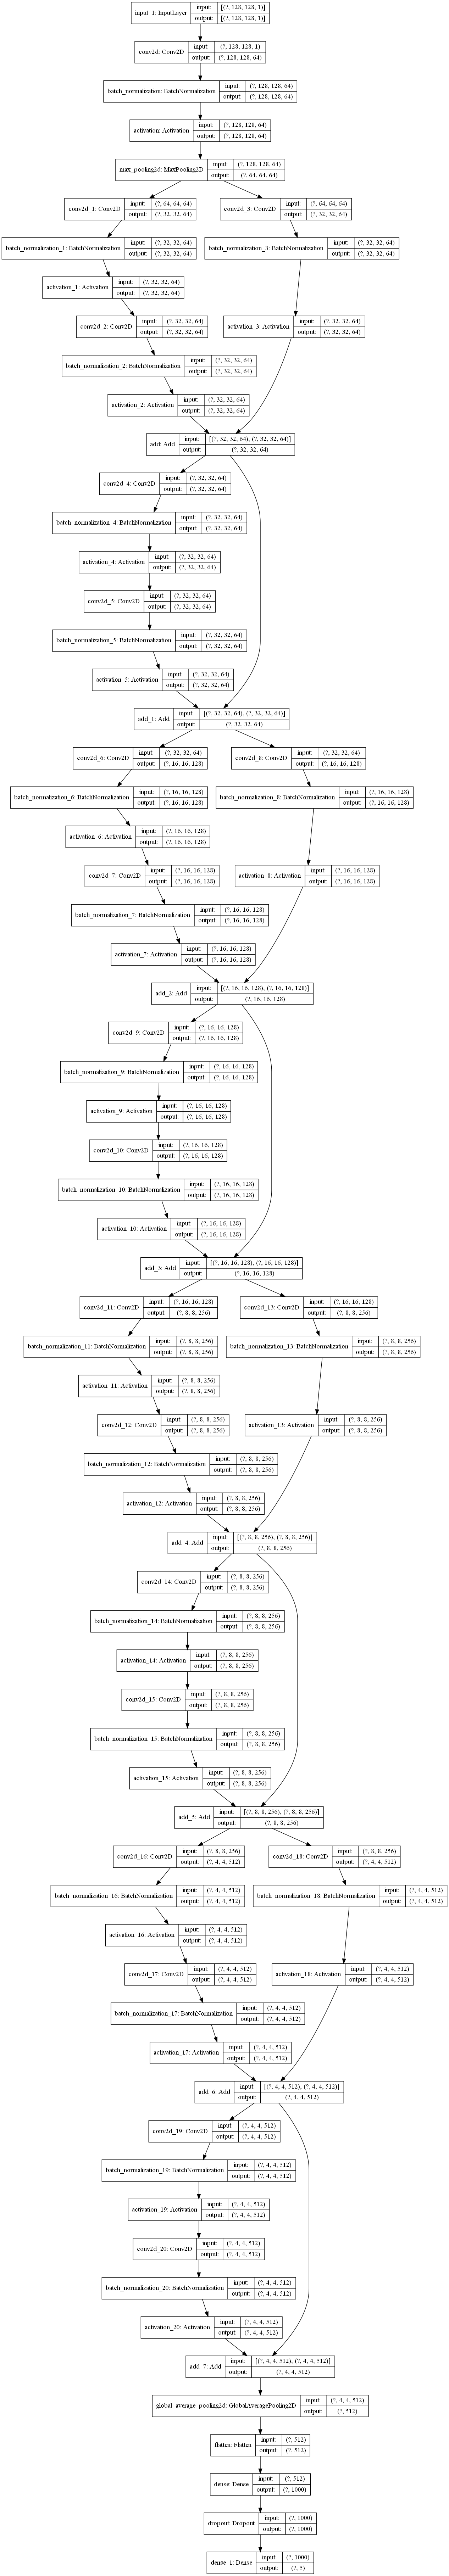

In [4]:
#model.summary()
plot_model(model,show_shapes=True,expand_nested=True)

In [8]:
index=10
print(np.shape(np.expand_dims(data_x[index,:,:,:],0)))
print(np.shape(np.expand_dims(data_y[index,:],0)))
model.compile(loss='mean_squared_error',optimizer='Adam')
history=model.fit(data_x,data_y,epochs=800,verbose=1,validation_split=0.2,use_multiprocessing=True)

(1, 128, 128, 1)
(1, 5)
Train on 8400 samples, validate on 2100 samples
Epoch 1/800
8400/8400 [==============================] - 63s 7ms/sample - loss: 0.6005 - val_loss: 70.5906
Epoch 2/800
8400/8400 [==============================] - 58s 7ms/sample - loss: 0.0926 - val_loss: 0.3251
Epoch 3/800
8400/8400 [==============================] - 55s 7ms/sample - loss: 0.0743 - val_loss: 0.4399
Epoch 4/800
8400/8400 [==============================] - 56s 7ms/sample - loss: 0.0571 - val_loss: 0.1529
Epoch 5/800
8400/8400 [==============================] - 55s 6ms/sample - loss: 0.0561 - val_loss: 0.0776
Epoch 6/800
8400/8400 [==============================] - 55s 7ms/sample - loss: 0.0471 - val_loss: 0.1447
Epoch 7/800
8400/8400 [==============================] - 55s 7ms/sample - loss: 0.0422 - val_loss: 0.1273
Epoch 8/800
8400/8400 [==============================] - 56s 7ms/sample - loss: 0.0367 - val_loss: 0.1341
Epoch 9/800
8400/8400 [==============================] - 55s 7ms/sample - loss:

InternalError: GPU sync failed

In [ ]:
t=history.history['loss']
plt.figure(figsize=(16,9))
plt.plot([i for i in range(np.shape(t)[0])],t)
plt.title('loss',fontsize=14)
plt.xlabel('iterations',fontsize=12)
plt.ylabel('MSE',fontsize=12)
#plt.xlim([0,100])

In [ ]:
index=105
print(np.shape(np.expand_dims(data_x[index],0)))
t=backend.function([model.input],[model.output])(np.expand_dims(data_x[index],0))
t_pred=np.squeeze(t).tolist()
t_true=np.squeeze(data_y[index]).tolist()
#t_input=np.squeeze(x_input).tolist()
print(t_pred)
print(t_true)

In [ ]:
model.save("C:\\Users\\Lenovo\\Desktop\\autocover_test\\resnet\\models\\my_model2.h5")

In [ ]:
import pickle
 
with open('C:\\Users\\Lenovo\\Desktop\\autocover_test\\resnet\\models\\trainHistory2.txt', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
#with open('trainHistoryDict.txt','rb') as file_pi:
#    history=pickle.load(file_pi)